In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os.path as op
import xarray as xr
import requests
from io import BytesIO
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append("../../../functions")
from tcs import Extract_Circle
from data_downloaders import download_ibtracs

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_tcs import Plot_TCs_HistoricalTracks_Category
from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat

from data_downloaders import  download_oni_index


In [2]:
lon_lat = [134.5, 5.5] #Palau location lon, lat
basin = 'WP'
r1 = 5 # Radius of the circular area in degrees

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    url = 'https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/IBTrACS.ALL.v04r01.nc'
    tcs = download_ibtracs(url, basin = basin)
    tcs.to_netcdf(f"{path_data}/tcs_{basin}.nc")
else:
    tcs = xr.load_dataset(f"{path_data}/tcs_{basin}.nc")

In [5]:
tcs = tcs.isel(storm = np.where(tcs.isel(date_time = 0).time.dt.year >= 1950)[0])    

In [6]:
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
    'wind': 'wmo_wind',
}
tcs_sel, tcs_sel_params = Extract_Circle(tcs, lon_lat[0], lon_lat[1], r1, d_vns, fillwinds=True)

In [7]:
tcs_sel_params['category'] = (('storm'), np.where(np.isnan(tcs_sel_params.category), -1, tcs_sel_params.category))

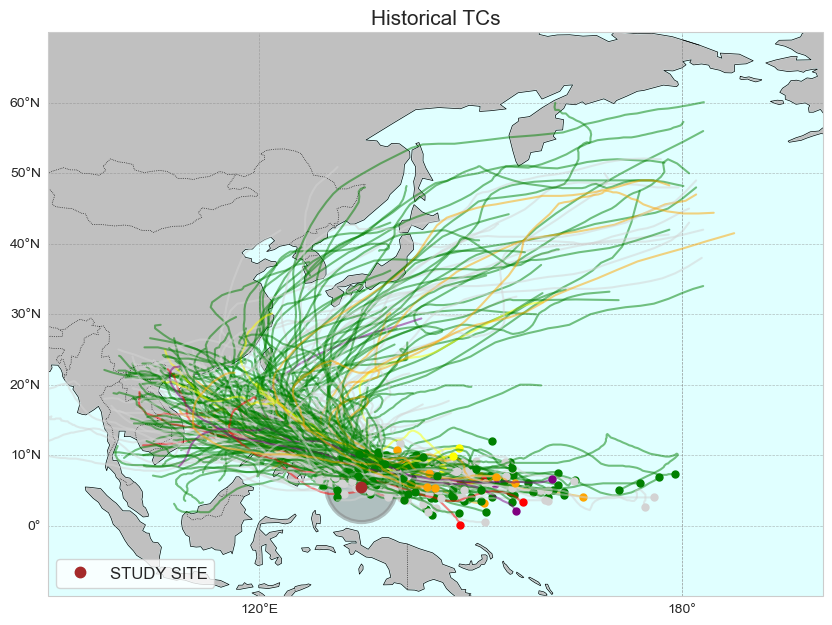

In [8]:
lon1, lon2 = 90, 200
lat1, lat2 = -10, 70

# r1
ax = Plot_TCs_HistoricalTracks_Category(
    tcs_sel, tcs_sel_params.category,
    lon1, lon2, lat1, lat2,
    lon_lat[0], lon_lat[1], r1,
)

In [9]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'

In [10]:
if update_data:
    df1 = download_oni_index(p_data)
    df1.to_pickle(op.join(path_data, 'oni_index.pkl'))
else:
    df1 = pd.read_pickle(op.join(path_data, 'oni_index.pkl'))

oni = df1

In [11]:
lims = [-.5, .5]
df1 = add_oni_cat(df1, lims = lims)

In [12]:
import pandas as pd
tcs_g = pd.DataFrame(tcs_sel.isel(date_time = 0).time.values)
tcs_g.index = tcs_g[0]
tcs_g.index = pd.DatetimeIndex(tcs_g.index).to_period('M').to_timestamp() + pd.offsets.MonthBegin(0)
tcs_g['oni_cat'] = oni.oni_cat

In [13]:
tcs_sel_params['oni_cat'] = (('storm'), tcs_g['oni_cat'].values)
tcs_sel['oni_cat'] = (('storm'), tcs_g['oni_cat'].values)

In [14]:
# oni['ONI_cat'] = np.where(oni.ONI < lims[0], -1, np.where(oni.ONI > lims[1], 1, 0))
tcs_sel_params['oni_cat'] = (('storm'), tcs_sel.oni_cat.values)

In [15]:
oni_perc_cat = oni.groupby('oni_cat').size() / oni.shape[0] * 100
oni_perc_cat

oni_cat
-1    33.783784
 0    36.486486
 1    29.729730
dtype: float64

In [16]:
tcs_perc_cat = tcs_sel_params.to_dataframe().groupby('oni_cat').size() * 100 / tcs_sel_params.to_dataframe().shape[0]
tcs_perc_cat

oni_cat
-1.0    30.746269
 0.0    43.283582
 1.0    25.373134
dtype: float64

In [17]:
#Relavice probability
tcs_perc_cat / oni_perc_cat

oni_cat
-1.0    0.910090
 0.0    1.186291
 1.0    0.853460
dtype: float64

In [18]:
time = tcs_sel_params.dmin_date.dt.year.values
u, cu = np.unique(time, return_counts=True)
tc_c = pd.DataFrame(cu, index = u)
time_sev = tcs_sel_params.where(tcs_sel_params.category >= 3, drop = True).dmin_date.dt.year.values
u_sev, cu_sev = np.unique(time_sev, return_counts=True)
tc_c_sev = pd.DataFrame(cu_sev, index = u_sev)

In [19]:
oni_y = oni.groupby(oni.index.year).min()
oni_y['tc_counts'] = tc_c
oni_y['tc_counts_sev'] = tc_c_sev

In [20]:
oni_y['oni_cat'] = oni_y.oni_cat.values

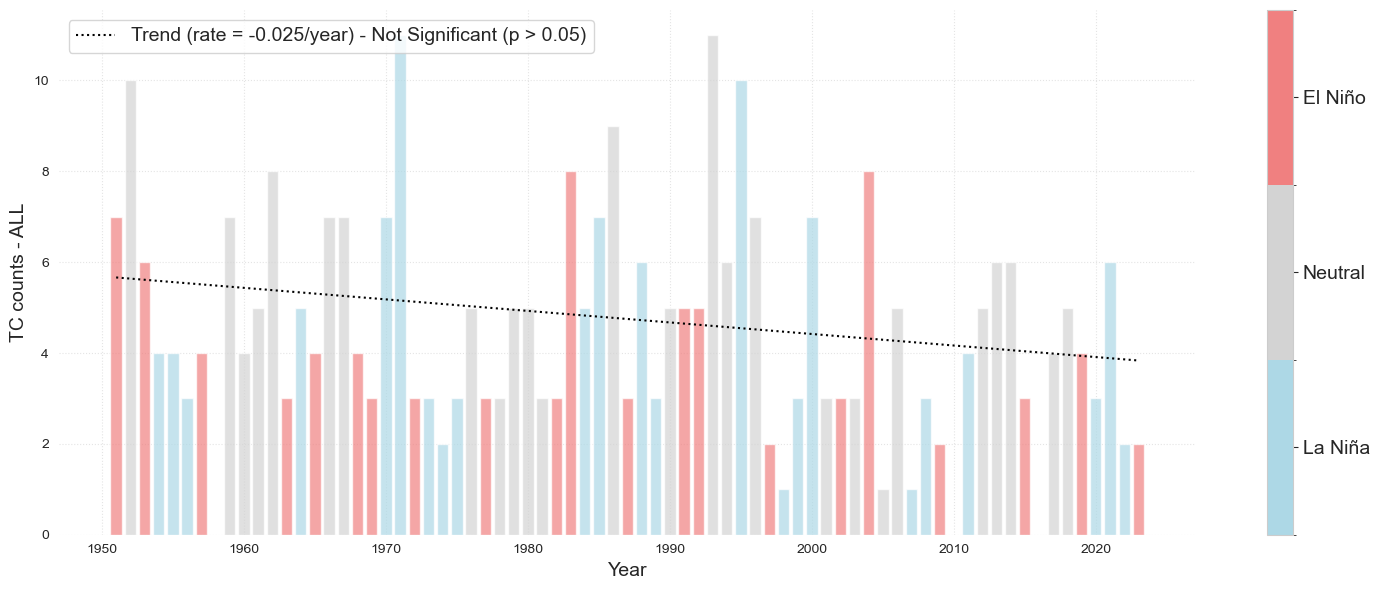

In [21]:
ax = plot_bar_probs_ONI(oni_y, 'tc_counts', y_label= 'TC counts - ALL');

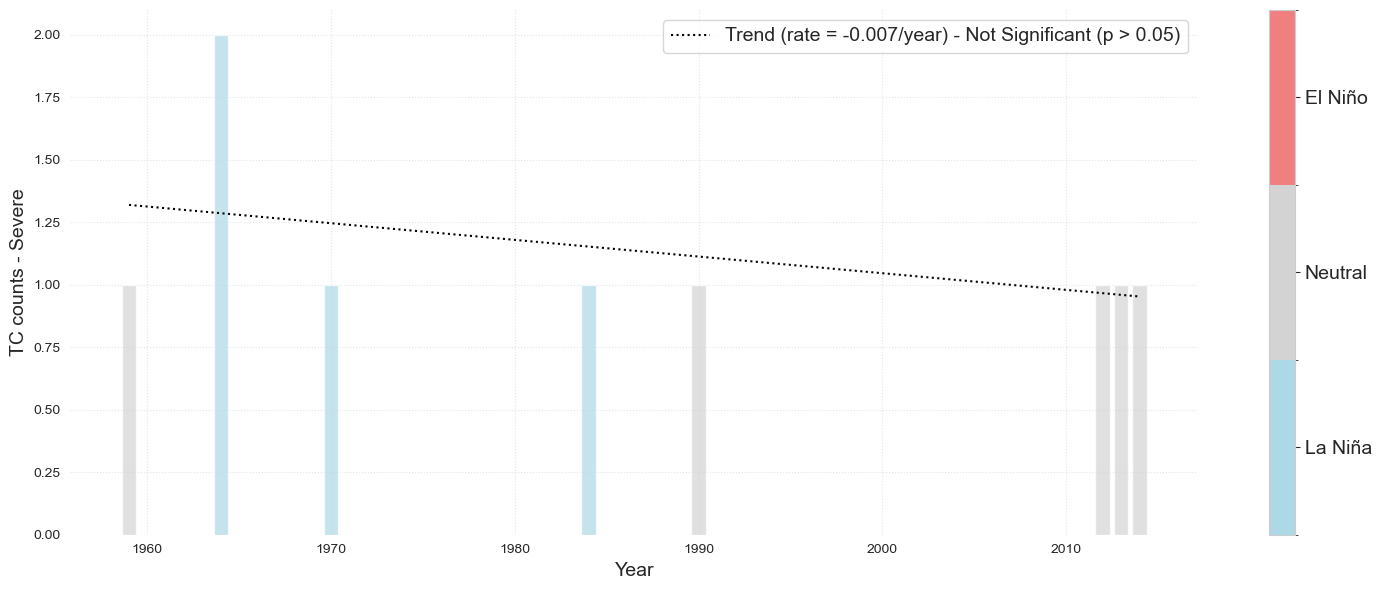

In [22]:
ax = plot_bar_probs_ONI(oni_y, 'tc_counts_sev', y_label= 'TC counts - Severe');
plt.savefig(op.join(path_figs, f'F9_TCs_severe_bars_trend.png'), dpi=300, bbox_inches='tight')



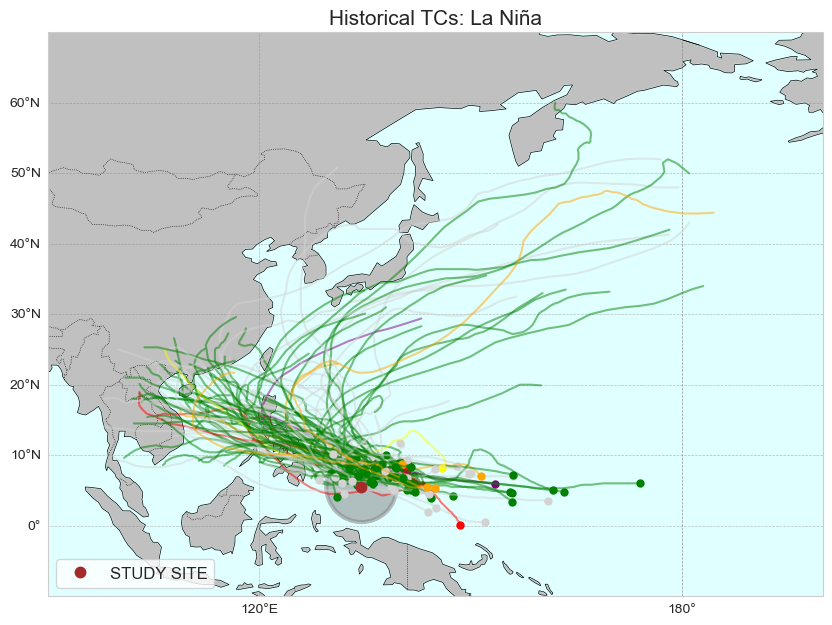

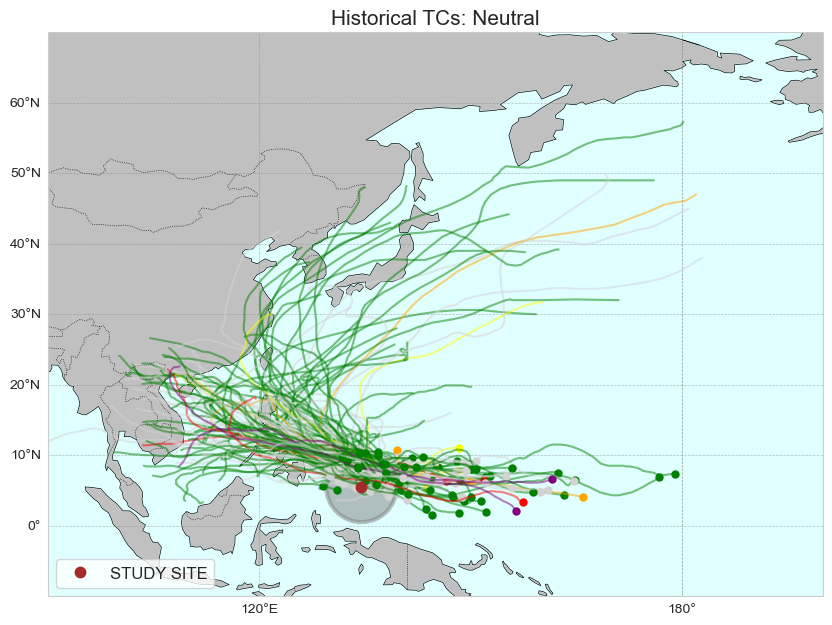

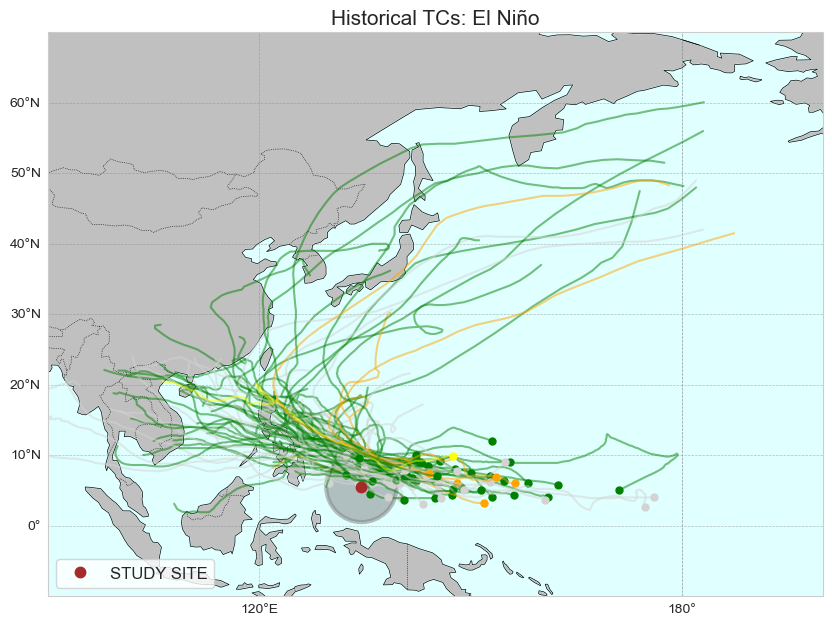

In [23]:
names_cat = ['La Niña', 'Neutral', 'El Niño']

for ic, category in enumerate([-1, 0, 1]):

    tcs_cat = tcs_sel.where(tcs_sel_params.oni_cat == category, drop = True)
    tcs_cat_params = tcs_sel_params.where(tcs_sel_params.oni_cat == category, drop = True)

    ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical TCs: {names_cat[ic]}', fontsize=15)

    plt.savefig(op.join(path_figs, f'F9_TCs_{names_cat[ic]}.png'), dpi=300, bbox_inches='tight')


In [24]:
storms_severe_ids = tcs_sel_params.storm.where(tcs_sel_params.category >= 3, drop = True).values

In [25]:
storms_severe = tcs_sel.sel(storm = storms_severe_ids)
storm_severe_params = tcs_sel_params.sel(storm = storms_severe_ids)

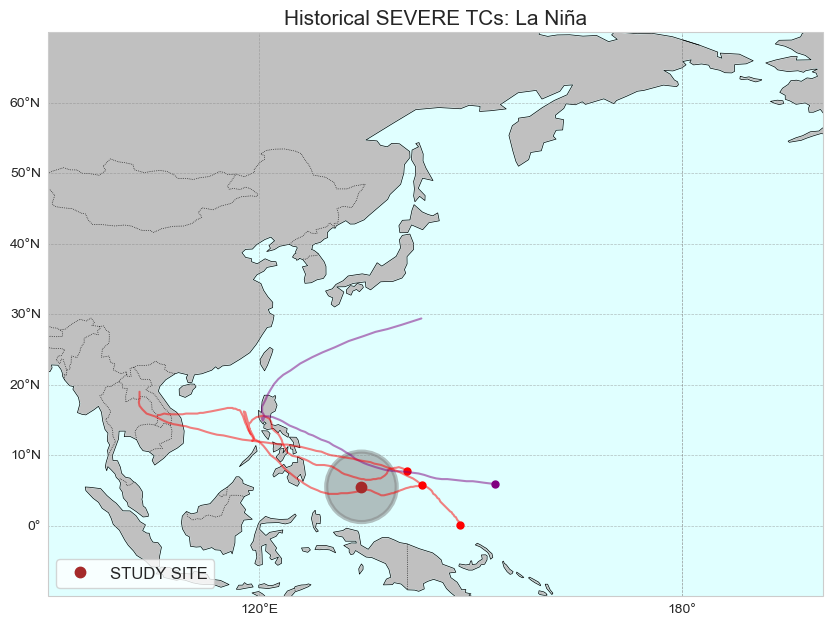

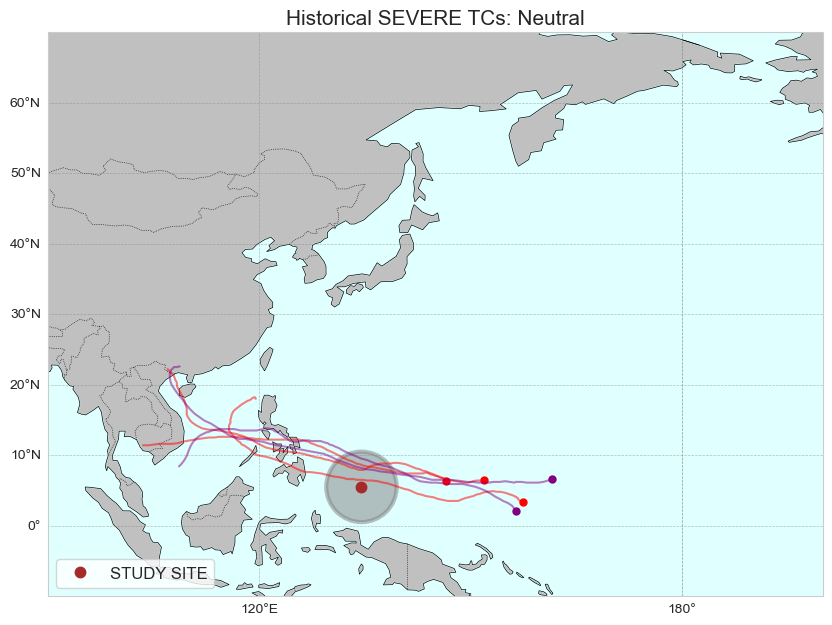

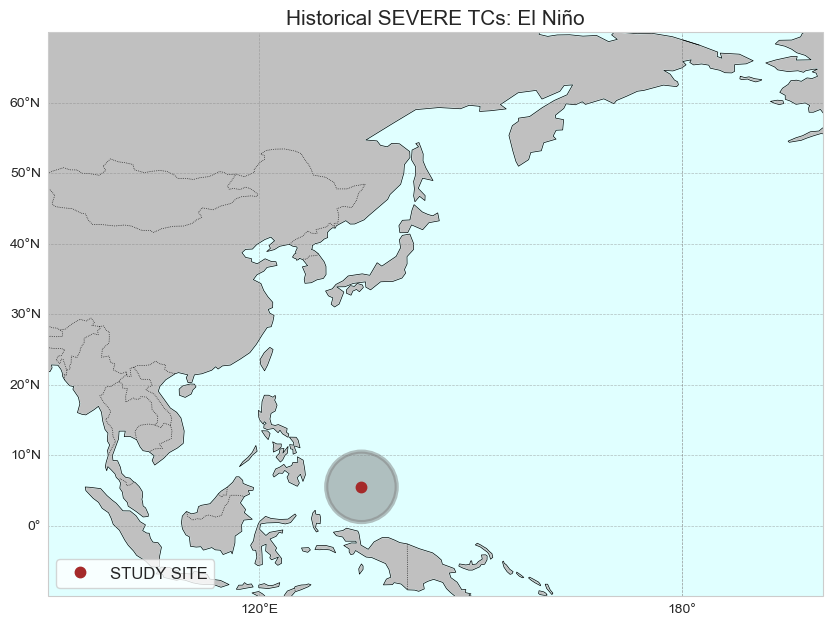

In [26]:
names_cat = ['La Niña', 'Neutral', 'El Niño']
for ic, category in enumerate([-1, 0, 1]):

    tcs_cat = storms_severe.where(storm_severe_params.oni_cat == category, drop = True)
    tcs_cat_params = storm_severe_params.where(storm_severe_params.oni_cat == category, drop = True)

    ax = Plot_TCs_HistoricalTracks_Category(
        tcs_cat, tcs_cat_params.category,
        lon1, lon2, lat1, lat2,
        lon_lat[0], lon_lat[1], r1,
    )
    ax.set_title(f'Historical SEVERE TCs: {names_cat[ic]}', fontsize=15)
    plt.savefig(op.join(path_figs, f'F9_TCs_{names_cat[ic]}_SEVERE.png'), dpi=300, bbox_inches='tight')
    